# Reweighting the Complex XY model

See, for example:
- https://link.springer.com/article/10.1007%2FJHEP08%282010%29020

The XY model has the following action
$$S=-\beta \sum_{x} \sum_{\nu=0}^{2} \cos \left(\phi_{x}-\phi_{x+\hat{\nu}}-i \mu \delta_{\nu, 0}\right).$$

The following functions compute the action from data generated by a lattice simulation and implement the complex reweighting method

## Code

In [3]:
import numpy as np
import pandas as pd

def get_action(data, dimensions, beta, mu):
    from mcmctools.utils.lattice import get_neighbour_index
    
    dim_mul = np.cumprod([1] + dimensions)
    lattice_configs = data["Config"].values
    elem_per_site = 1
    n_elems = np.size(lattice_configs, axis=1)

    n_sites = int(np.prod(dimensions))
    N = int(n_elems / n_sites)

    lattice_configs = lattice_configs.reshape(len(data), -1, N)
    

    actions = np.zeros(len(data), dtype=np.complex64)
    for site in range(n_sites):
        neighbour_indices = np.zeros(len(dimensions), dtype=int)
        for dim in range(len(dimensions)):
            neighbour_indices[dim] = get_neighbour_index(n=site, dim=dim, direction=True, mu=0,
                                                         dimensions=dimensions, dim_mul=dim_mul, elem_per_site=elem_per_site)
        
        delta_nu_0 = np.zeros((len(data),3))
        delta_nu_0[:,0] = 1.0
        
        actions += -beta*np.sum(np.cos(lattice_configs[:, site] - lattice_configs[:, neighbour_indices].reshape(len(data),3) - 1j*mu*delta_nu_0), axis=1)

    return actions


def get_phase_factor(data, dimensions, src_params, tar_params):
    #print(np.max((-1.0 * (get_action(data=data, dimensions=dimensions, beta=tar_params["beta"], mu = tar_params["mu"]) -
                          #get_action(data=data, dimensions=dimensions, beta=src_params["beta"], mu = src_params["mu"])))))
    
    return np.exp((-1.0 * (get_action(data=data, dimensions=dimensions, beta=tar_params["beta"], mu = tar_params["mu"]) -
                          get_action(data=data, dimensions=dimensions, beta=src_params["beta"], mu = src_params["mu"]))).astype(np.complex128))


def error_computation_fraction(nominator, denominator, nominator_err, denominator_err):
    real_x = lambda x, y, a, b: a / (a * a + b * b)
    real_y = lambda x, y, a, b: b / (a * a + b * b)
    real_a = lambda x, y, a, b: (-a * a * x + b * b * x - 2 * a * b * y)/ ((a * a + b * b) * (a * a + b * b))
    real_b = lambda x, y, a, b: (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))

    imag_x = lambda x, y, a, b: -1.0 * b / (a * a + b * b)
    imag_y = real_x
    imag_a = lambda x, y, a, b: -1.0 * (a * a * y - b * b * y - 2 * a * b * x)/ ((a * a + b * b) * (a * a + b * b))
    imag_b = real_a

    nom_re_err = np.real(nominator_err)
    nom_im_err = np.imag(nominator_err)
    dom_re_err = np.real(denominator_err)
    dom_im_err = np.imag(denominator_err)

    real_error = 0.0
    for err_contr, err in zip([real_x, real_y, real_a, real_b], [nom_re_err, nom_im_err, dom_re_err, dom_im_err]):
        real_error += np.power(err_contr(
            np.real(nominator), np.imag(nominator), np.real(denominator), np.imag(denominator)), 2.0) * np.power(err, 2.0)
    real_error = np.sqrt(real_error)

    imag_error = 0.0
    for err_contr, err in zip([imag_x, imag_y, imag_a, imag_b], [nom_re_err, nom_im_err, dom_re_err, dom_im_err]):
        imag_error += np.power(err_contr(
            np.real(nominator), np.imag(nominator), np.real(denominator), np.imag(denominator)), 2.0) * np.power(err, 2.0)
    imag_error = np.sqrt(imag_error)
    
    return real_error + 1.0j * imag_error


def reweight(data, phase_factor, observable, tar_params, dimensions):
    from scipy import stats
    nominator = observable(x=data, params=tar_params, dimensions=dimensions).astype(np.complex128) * phase_factor
    mask = ~np.any([np.real(nominator) < -1e8, np.real(nominator) > 1e8, np.imag(nominator) < -1e8, np.imag(nominator) > 1e8], axis=0)
    
    nominator_err = stats.sem(np.real(nominator[mask])) + 1.0j * stats.sem(np.imag(nominator[mask]))
    phase_factor_err = stats.sem(np.real(phase_factor[mask])) + 1.0j * stats.sem(np.imag(phase_factor[mask]))
    
    nominator = nominator[mask].mean()
    phase_factor = phase_factor[mask].mean()
    
    if np.sum(~mask) > 100000:
        print("More than 100000 unsuable samples for computation of observables")

    return nominator / phase_factor, error_computation_fraction(
        nominator=nominator, denominator=phase_factor, nominator_err=nominator_err, denominator_err=phase_factor_err)


def action_density(x, params, dimensions):
    return get_action(x, dimensions, params["beta"], params["mu"])/np.prod(dimensions)


def reweight_results_mulitple_targets(data, src_params, observables, tar_params, dimensions): #format of src_param = {"beta": h, "mu": mu}
    from scipy import stats
    
    results = {"re_phase_factor": [], "re_phase_factor_err": [], "src_beta": [], "src_mu": []}
    results = {"tar_beta": tar_params["beta"], "tar_mu": tar_params["mu"],
               **results, **{"re_" + key: [] for key in list(observables.keys())},
               **{"re_" + key + "_err": [] for key in list(observables.keys())}}
    
    src_param = src_params
    
    from tqdm import tqdm
    for beta, mu in tqdm(zip(tar_params["beta"], tar_params["mu"])):
        tar_param = {"beta": beta, "mu": mu}
        phase_factor = get_phase_factor(data=data, dimensions=dimensions, src_params=src_param, tar_params=tar_param)
        mask = ~np.any([np.real(phase_factor) < -1e8, np.real(phase_factor) > 1e8, np.imag(phase_factor) < -1e8, np.imag(phase_factor) > 1e8], axis=0)
        
        if np.sum(~mask) > 5000:
            print("More than 5000 unsuable samples for computation of phase factor")
        
        results["re_phase_factor"].append(phase_factor[mask].mean())
        results["re_phase_factor_err"].append(stats.sem(np.real(phase_factor[mask])) + 1.0j * stats.sem(np.imag(phase_factor[mask])))
        results["src_beta"].append(src_param["beta"])
        results["src_mu"].append(src_param["mu"])
        
        for key, observable in observables.items():
            try:
                re_observable, re_observable_err = reweight(
                    data=data.iloc[mask], phase_factor=phase_factor[mask], observable=observable, tar_params=tar_param, dimensions=dimensions)
                
            except:
                re_observable = "fail"
                re_observable_err = "fail"
                    
            results["re_" + key].append(re_observable)
            results["re_" + key + "_err"].append(re_observable_err)
            
            
    results = pd.DataFrame(results)
    return results


def get_M(src_data, tar_data, src_param, tar_param, N, observables, dimensions): # src_data, tar_data, , observables, dimensions
    
    src_vector = np.array(list(src_param.values()))
    tar_vector = np.array(list(tar_param.values()))
    
    diff_vector = tar_vector - src_vector
    step_vector = diff_vector/N
    
    num_params = len(src_vector)
    
    steps_array = np.zeros((N+1,num_params))
    
    for j in range(N+1):
        steps_array[j,:] = src_vector + j*step_vector
    
    param_names = list(src_param.keys())
    inter_tar_params = {param_names[0]: steps_array[:,0], param_names[1]: steps_array[:,1]}
    
    obs_from_src = reweight_results_mulitple_targets(src_data, src_param, observables, inter_tar_params, dimensions)
    obs_from_tar = reweight_results_mulitple_targets(tar_data, tar_param, observables, inter_tar_params, dimensions)
    
    diff = np.nan_to_num(np.array(obs_from_tar["re_E"] - obs_from_src["re_E"]).real)
    
    print("obs from target:", np.array(obs_from_tar["re_E"]).real)
    print("obs from source:", np.array(obs_from_src["re_E"]).real)
    
    print("difference:", diff)
                                               
    M = np.sqrt(np.sum(diff**2))
    
    return M


# Examples for arguments:
# params = {"beta": [0.7, ...], "mu": [0.0, 0.1, ...]}
# dimensions = [2,2,2]
# data_sets is a list of the data for each parameter configuration -> data_sets = [data_0, data_1, ...]

def do_stepwise_reweighting_E(data_sets, params, N, dimensions): 
    
    observables = {"E":  action_density}
    
    num_configs = len(params["mu"])
    
    global M_values
    
    M_values = np.zeros(num_configs-1)
    
    for i in range(num_configs-1):
        
        src_data = data_sets[i]
        src_beta = params["beta"][i]
        src_mu = params["mu"][i]
        
        src_param = {"beta": src_beta, "mu": src_mu}
        
        tar_data = data_sets[i+1]
        tar_beta = params["beta"][i+1]
        tar_mu = params["mu"][i+1]
        
        tar_param = {"beta": tar_beta, "mu": tar_mu}
        
        try:
            M_values[i] = get_M(src_data, tar_data, src_param, tar_param, N, observables, dimensions)
        
        except:
            M_values[i] = None
        
    #return np.array(M_values)
    
    
def get_data_sets(data, params, num_samples):
    num_params = len(params["mu"])
    data_sets = []
    for i in range(num_params):
        data_sets.append(data.iloc[i*num_samples:(i+1)*num_samples, :])
    return data_sets

## Results

### 1. Load data

In [125]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to examples/ directory as project root directory
    import os
    os.chdir("../ComplexXYModel")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./python_scripts")

In [126]:
from mcmctools.mcmc.evaluation_module import EvaluationModule
from mcmctools.utils.utils import linspace_rp_intervals
evaluation_module = EvaluationModule(sim_base_dir="./", rel_data_dir="data/ComplexXYModelComplexLangevin_mu0to15_beta05_26/",
                                     rel_results_dir="results/ComplexXYModelComplexLangevin_mu0to15_beta05_26/",
                                     running_parameter_kind=None,
                                     running_parameter="mu",
                                     rp_values=linspace_rp_intervals(0.0, 1.5, 26))

In [127]:
expectation_values = evaluation_module.load_expectation_values()
expectation_values

val,Estimate,Error,Estimate,Error,Estimate,Error
quantity,Energy,Energy,Mean,Mean,Mu,Mu
mu,,,,,,
0.000000,-0.733922+0.000000j,0.001680+0.000000j,3.139751+0.000000j,0.008115+0.000000j,0.00+0.00j,0.000000e+00+0.000000e+00j
0.060000,-0.740112+0.000080j,0.001611+0.000364j,3.408196+0.000000j,0.012234+0.000000j,0.06+0.00j,2.414906e-17+0.000000e+00j
0.120000,-0.733910-0.000920j,0.001947+0.000447j,3.083773+0.000000j,0.014616+0.000000j,0.12+0.00j,4.829812e-17+0.000000e+00j
0.180000,-0.753534-0.000633j,0.001881+0.000489j,3.154761+0.000000j,0.015116+0.000000j,0.18+0.00j,1.361129e-16+0.000000e+00j
0.240000,-0.779782-0.001097j,0.001420+0.000470j,3.023807+0.000000j,0.017607+0.000000j,0.24+0.00j,9.659623e-17+0.000000e+00j
0.300000,-0.791259-0.000232j,0.001589+0.000529j,3.494009+0.000000j,0.011125+0.000000j,0.30+0.00j,1.791421e-16+0.000000e+00j
0.360000,-0.815085-0.001842j,0.001710+0.000490j,3.063428+0.000000j,0.013062+0.000000j,0.36+0.00j,2.722257e-16+0.000000e+00j
0.420000,-0.822723+0.002024j,0.001779+0.000608j,2.737745+0.000000j,0.008129+0.000000j,0.42+0.00j,8.957105e-17+0.000000e+00j


In [128]:
data = evaluation_module.load_data()
data

quantity                         Energy                Mean   Mu  \
elem                                                               
mu       sample_num                                                
0.000000 0          -0.893717+0.000000j  3.317018+0.000000j  0.0   
         1          -0.892679+0.000000j  3.203399+0.000000j  0.0   
         2          -0.919021+0.000000j  3.317367+0.000000j  0.0   
         3          -0.912584+0.000000j  3.338384+0.000000j  0.0   
         4          -0.846904+0.000000j  3.229765+0.000000j  0.0   
...                                 ...                 ...  ...   
1.500000 995        -1.565719-0.018387j  4.932383+0.000000j  1.5   
         996        -1.597101+0.045442j  4.854597+0.000000j  1.5   
         997        -1.565898-0.007250j  4.931124+0.000000j  1.5   
         998        -1.542004+0.005607j  4.913220+0.000000j  1.5   
         999        -1.554459+0.006051j  4.769932+0.000000j  1.5   

quantity                         Config                      \
elem                                  0                   1   
mu       sample_num                                           
0.000000 0           5.503763+0.000000j  1.279691+0.000000j   
         1           5.489377+0.000000j  1.616222+0.000000j   
         2           5.446085+0.000000j  1.322877+0.000000j   
         3           6.187599+0.000000j  0.261010+0.000000j   
         4           6.131501+0.000000j  0.500750+0.000000j   
...                                 ...                 ...   
1.500000 995         4.727916+0.069978j  4.121399-0.020261j   
         996         5.340692+0.067758j  3.938877-0.017247j   
         997         5.164887+0.046117j  3.347259-0.025900j   
         998         5.939735-0.066998j  3.438220+0.038553j   
         999         5.603742-0.260043j  3.258937+0.154756j   

quantity                                                     \
elem                                  2                   3   
mu       sample_num                                           
0.000000 0           0.463013+0.000000j  1.171985+0.000000j   
         1           0.251559+0.000000j  1.101727+0.000000j   
         2           0.225447+0.000000j  1.301967+0.000000j   
         3           6.270100+0.000000j  1.686727+0.000000j   
         4           0.431306+0.000000j  1.195740+0.000000j   
...                                 ...                 ...   
1.500000 995         4.896845-0.254886j  0.100602+0.217118j   
         996         5.560351-0.146965j  5.863209+0.159016j   
         997         5.315548-0.013629j  5.788087+0.109213j   
         998         4.744985-0.000020j  5.879686+0.139215j   
         999         5.272536+0.014154j  0.286909+0.205267j   

quantity                                                     \
elem                                  4                   5   
mu       sample_num                                           
0.000000 0           0.491791+0.000000j  0.900800+0.000000j   
         1           5.652717+0.000000j  0.336186+0.000000j   
         2           6.089450+0.000000j  0.101686+0.000000j   
         3           6.135294+0.000000j  5.629551+0.000000j   
         4           0.899611+0.000000j  5.242268+0.000000j   
...                                 ...                 ...   
1.500000 995         5.624081+0.034798j  5.767362-0.015778j   
         996         6.037746+0.034887j  5.263475-0.001390j   
         997         5.670888+0.040571j  5.217994-0.023629j   
         998         0.286776+0.023662j  5.588446-0.037426j   
         999         0.927158+0.013843j  0.056595-0.004803j   

quantity                                 ...                      \
elem                                  6  ...                 502   
mu       sample_num                      ...                       
0.000000 0           5.631530+0.000000j  ...  5.715422+0.000000j   
         1           5.853942+0.000000j  ...  0.377633+0.000000j   
         2           5.694640+0.000000j  ...  0.497289+0.0

In [129]:
first_mu=data.index[0][0]
first_mu_data = data.loc[first_mu,:]
num_samples = len(first_mu_data.index)
num_samples

1000

### 2. Create params object, set other variables, and get data_sets list

In [130]:
mu_values = list(np.array(data["Mu"])[::num_samples])
beta = 0.5
beta_values = [beta for _ in range(len(mu_values))]
params = {"beta": beta_values, "mu": mu_values}
print(params)


{'beta': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'mu': [0.0, 0.06, 0.12, 0.18, 0.24, 0.3, 0.36, 0.42, 0.48, 0.54, 0.6, 0.66, 0.72, 0.78, 0.84, 0.9, 0.96, 1.02, 1.08, 1.14, 1.2, 1.26, 1.32, 1.38, 1.44, 1.5]}


In [135]:
dimensions = [8,8,8] #neeeds to be set manually
num_steps = 5
print(len(mu_values)*num_samples)

data_sets = get_data_sets(data, params, num_samples)

26000


### 3. Return M_values

In [136]:
do_stepwise_reweighting_E(data_sets, params, num_steps, dimensions)
#np.savetxt("M_values.txt", M_values)
M_values

6it [00:02,  2.80it/s]
6it [00:02,  2.48it/s]


obs from target: [-0.72994956 -0.73922299 -0.7409722  -0.73909266 -0.73917658 -0.74011173]
obs from source: [-0.73392164 -0.73398215 -0.73416498 -0.73446887 -0.73489592 -0.73544574]
difference: [ 0.00397207 -0.00524084 -0.00680722 -0.00462379 -0.00428067 -0.00466599]


6it [00:02,  2.25it/s]
6it [00:03,  1.87it/s]


obs from target: [-0.72748236 -0.72840847 -0.72948228 -0.73072783 -0.73218339 -0.73391043]
obs from source: [-0.74011173 -0.7407113  -0.74125437 -0.74201515 -0.74293357 -0.74394401]
difference: [0.01262937 0.01230282 0.01177209 0.01128732 0.01075019 0.01003358]


6it [00:03,  1.73it/s]
6it [00:02,  2.18it/s]


obs from target: [-0.7458863  -0.74703328 -0.74837456 -0.7499054  -0.75162539 -0.75353401]
obs from source: [-0.73391043 -0.73603336 -0.73878332 -0.74252382 -0.74765023 -0.75474456]
difference: [-0.01197587 -0.01099992 -0.00959124 -0.00738158 -0.00397516  0.00121055]


6it [00:02,  2.42it/s]
6it [00:02,  2.06it/s]


obs from target: [-0.77064585 -0.77223665 -0.77433144 -0.77631756 -0.77810417 -0.7797821 ]
obs from source: [-0.75353401 -0.75563143 -0.75792223 -0.76041175 -0.76310775 -0.76602087]
difference: [-0.01711184 -0.01660522 -0.01640922 -0.01590581 -0.01499643 -0.01376124]


6it [00:02,  2.23it/s]
6it [00:02,  2.48it/s]


obs from target: [-0.77963091 -0.78183338 -0.78412712 -0.78646819 -0.78883939 -0.79125902]
obs from source: [-0.7797821  -0.78148431 -0.78332007 -0.78529691 -0.78719012 -0.78840805]
difference: [ 0.00015119 -0.00034907 -0.00080706 -0.00117128 -0.00164927 -0.00285097]


6it [00:02,  2.44it/s]
6it [00:02,  2.37it/s]


obs from target: [-0.79770985 -0.80129515 -0.80488727 -0.80837026 -0.81174334 -0.81508518]
obs from source: [-0.79125902 -0.79378501 -0.79650825 -0.79952251 -0.80287448 -0.80650145]
difference: [-0.00645083 -0.00751015 -0.00837901 -0.00884775 -0.00886886 -0.00858373]


6it [00:02,  2.44it/s]
6it [00:02,  2.49it/s]


obs from target: [-0.80669258 -0.80910955 -0.81190492 -0.81513759 -0.81877338 -0.82272345]
obs from source: [-0.81508518 -0.81847192 -0.82191911 -0.82537224 -0.82875163 -0.83201805]
difference: [0.00839259 0.00936237 0.01001419 0.01023465 0.00997825 0.0092946 ]


6it [00:02,  2.49it/s]
6it [00:02,  2.51it/s]


obs from target: [-0.83383507 -0.8381981  -0.84227517 -0.8462803  -0.85032666 -0.85446859]
obs from source: [-0.82272345 -0.82689257 -0.83124928 -0.83590033 -0.84108586 -0.84696427]
difference: [-0.01111162 -0.01130553 -0.0110259  -0.01037997 -0.0092408  -0.00750433]


6it [00:03,  1.64it/s]
6it [00:03,  1.58it/s]


obs from target: [-0.87109295 -0.87417804 -0.87763085 -0.88135412 -0.88526836 -0.88933516]
obs from source: [-0.85446859 -0.85872596 -0.86310229 -0.86759402 -0.87219641 -0.87690844]
difference: [-0.01662436 -0.01545208 -0.01452855 -0.0137601  -0.01307195 -0.01242672]


6it [00:03,  1.80it/s]
6it [00:03,  1.81it/s]


obs from target: [-0.87492962 -0.87590754 -0.87853039 -0.882505   -0.88751816 -0.89325707]
obs from source: [-0.88933516 -0.89356848 -0.89802488 -0.90279268 -0.90797008 -0.91365672]
difference: [0.01440554 0.01766094 0.01949449 0.02028769 0.02045192 0.02039966]


6it [00:03,  1.86it/s]
6it [00:03,  1.86it/s]


obs from target: [-0.90961767 -0.9138959  -0.91948787 -0.92516137 -0.93060651 -0.93621585]
obs from source: [-0.89325707 -0.89944171 -0.90583744 -0.91224384 -0.9184667  -0.9242775 ]
difference: [-0.0163606  -0.0144542  -0.01365044 -0.01291753 -0.01213981 -0.01193835]


6it [00:03,  1.86it/s]
6it [00:03,  1.87it/s]


obs from target: [-0.93553827 -0.94315562 -0.94914249 -0.95455922 -0.96005141 -0.96584846]
obs from source: [-0.93621585 -0.94224696 -0.94856973 -0.95499569 -0.96154808 -0.96833096]
difference: [ 0.00067758 -0.00090866 -0.00057276  0.00043647  0.00149666  0.0024825 ]


6it [00:03,  1.91it/s]
6it [00:03,  1.78it/s]


obs from target: [-0.95320903 -0.96010823 -0.96684986 -0.97352302 -0.98020864 -0.98697896]
obs from source: [-0.96584846 -0.97191122 -0.97810265 -0.98430323 -0.99045418 -0.9965359 ]
difference: [0.01263943 0.01180299 0.01125279 0.01078021 0.01024553 0.00955694]


6it [00:03,  1.84it/s]
6it [00:03,  1.86it/s]


obs from target: [-1.00147788 -1.00519691 -1.01005921 -1.01570899 -1.02185742 -1.02830363]
obs from source: [-0.98697896 -0.99388616 -1.00096294 -1.00823591 -1.0157611  -1.02377475]
difference: [-0.01449893 -0.01131075 -0.00909627 -0.00747308 -0.00609632 -0.00452888]


6it [00:03,  1.80it/s]
6it [00:03,  1.86it/s]


obs from target: [-1.03812643 -1.04501109 -1.05202953 -1.05907981 -1.06613836 -1.07318905]
obs from source: [-1.02830363 -1.0349315  -1.04169388 -1.04858938 -1.05564067 -1.06287261]
difference: [-0.0098228  -0.01007959 -0.01033565 -0.01049044 -0.01049769 -0.01031644]


6it [00:03,  1.83it/s]
6it [00:03,  1.84it/s]


obs from target: [-1.0697146  -1.08354286 -1.0876075  -1.0921458  -1.09860646 -1.10622067]
obs from source: [-1.07318905 -1.08003542 -1.08603159 -1.09041863 -1.09607659 -1.12245467]
difference: [ 0.00347445 -0.00350744 -0.00157591 -0.00172717 -0.00252987  0.016234  ]


6it [00:03,  1.83it/s]
6it [00:03,  1.82it/s]


obs from target: [-1.1127269  -1.12058914 -1.12872204 -1.1371337  -1.14582452 -1.1547592 ]
obs from source: [-1.10622067 -1.11437499 -1.12299895 -1.13246845 -1.14371169 -1.15855846]
difference: [-0.00650623 -0.00621415 -0.00572309 -0.00466524 -0.00211283  0.00379926]


6it [00:03,  1.87it/s]
6it [00:03,  1.76it/s]


obs from target: [-1.15455112 -1.16314086 -1.17067134 -1.17943891 -1.18896599 -1.1976482 ]
obs from source: [-1.1547592  -1.16376199 -1.17221455 -1.17828937 -1.17706302 -1.15358857]
difference: [ 0.00020808  0.00062113  0.0015432  -0.00114954 -0.01190297 -0.04405963]


6it [00:03,  1.82it/s]
6it [00:03,  1.85it/s]


obs from target: [-1.7108154  -1.2627479  -1.22764194 -1.22825996 -1.23712351 -1.24709653]
obs from source: [-1.1976482  -1.20668339 -1.21644263 -1.22557707 -1.23433924 -1.24298715]
difference: [-0.5131672  -0.05606451 -0.01119931 -0.00268289 -0.00278427 -0.00410939]


6it [00:03,  1.83it/s]
6it [00:03,  1.81it/s]


obs from target: [-1.25031025 -1.2562347  -1.2640866  -1.27372924 -1.28408317 -1.2938787 ]
obs from source: [-1.24709653 -1.2564532  -1.26611376 -1.27548652 -1.27991004 -1.29217033]
difference: [-0.00321372  0.00021849  0.00202716  0.00175728 -0.00417314 -0.00170837]


6it [00:03,  1.85it/s]
6it [00:03,  1.88it/s]


obs from target: [-1.29022401 -1.3017962  -1.31330783 -1.32476307 -1.33620264 -1.34771737]
obs from source: [-1.2938787  -1.30391666 -1.31482818 -1.3255651  -1.33613271 -1.34344882]
difference: [ 3.65469169e-03  2.12045726e-03  1.52034226e-03  8.02030737e-04
 -6.99289327e-05 -4.26855298e-03]


6it [00:03,  1.84it/s]
6it [00:03,  1.85it/s]


obs from target: [-1.03630023 -1.13036936 -1.38086001 -1.37190662 -1.3834615  -1.39603535]
obs from source: [-1.34771737 -1.35954768 -1.3723192  -1.38761798 -1.39457511 -1.35559587]
difference: [ 0.31141715  0.22917831 -0.00854081  0.01571136  0.01111361 -0.04043948]


6it [00:03,  1.87it/s]
6it [00:03,  1.82it/s]


obs from target: [-1.3903444  -1.40428604 -1.42128472 -1.43460633 -1.44592053 -1.45759494]
obs from source: [-1.39603535 -1.40823909 -1.42112491 -1.43607869 -1.44203415 -1.32683136]
difference: [ 0.00569094  0.00395305 -0.00015981  0.00147235 -0.00388639 -0.13076357]


6it [00:03,  1.99it/s]
6it [00:03,  1.84it/s]


obs from target: [-1.47103824 -1.48265715 -1.49455461 -1.50670128 -1.51905149 -1.53157348]
obs from source: [-1.45759494 -1.46996112 -1.48261117 -1.49540289 -1.50132913 -1.39383509]
difference: [-0.0134433  -0.01269603 -0.01194344 -0.01129839 -0.01772236 -0.13773839]


5it [00:02,  1.95it/s]<ipython-input-3-c34e84d75f2a>:113: RuntimeWarning: Mean of empty slice.
  results["re_phase_factor"].append(phase_factor[mask].mean())
/home/adrian/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home/adrian/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/adrian/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/adrian/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
6it [00:02,  2.02it/s]
6it [00:03,  1.91it/s]


array([0.01229052, 0.02816177, 0.02069219, 0.03879523, 0.00360778,
       0.01997106, 0.02343238, 0.02494603, 0.03522577, 0.04631934,
       0.03346176, 0.0031947 , 0.02717002, 0.02311746, 0.02513147,
       0.01731426, 0.0124243 , 0.0456844 , 0.51637299, 0.00615684,
       0.00624766, 0.38933532, 0.13101307, 0.14106083,        nan])

### 4. Plot M_values

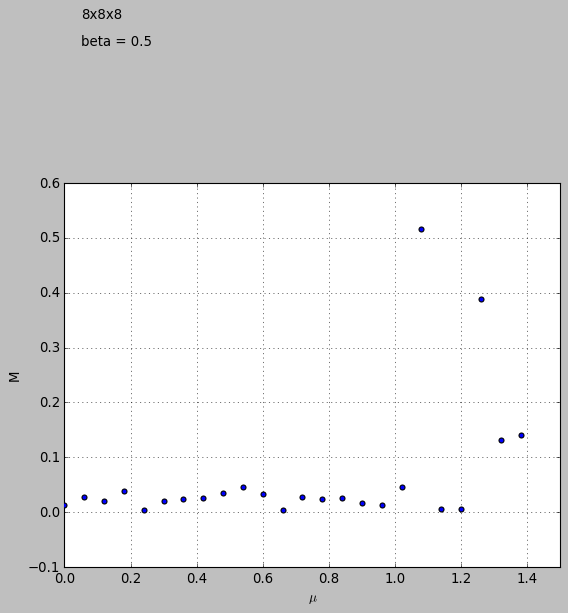

In [137]:
import matplotlib.pyplot as plt
plt.style.use('classic')

plt.scatter(mu_values[:-1], M_values[:], zorder=3)
plt.xlabel("$\mu$")
plt.ylabel("M")
plt.grid(zorder=0)
plt.xlim(0,1.5)

plt.text(0.05, 0.9,"8x8x8")
plt.text(0.05, 0.85,"beta = {}".format(beta))
fig1 = plt.gcf()

In [138]:
fig1.savefig("../jupyter_notebooks/reweighting_plots/beta{}_26_again".format(int(beta*10)), dpi=100)

In [58]:
mu_values

[0.0, 0.447214]

In [29]:
np.sqrt(0.2)

0.4472135954999579